In [4]:
%load_ext autoreload
%autoreload 1
%matplotlib inline

import os
import subprocess

os.chdir(subprocess.check_output("echo $MB", shell=True)\
         .decode("UTF-8").strip())
%aimport project_config

from collections import defaultdict, OrderedDict
import multiprocessing as mp
import pickle
import re
import sys
import warnings

warnings.simplefilter("ignore", FutureWarning)

from joblib import Parallel, delayed
import numpy as np
import pandas as pd
from tqdm import tqdm, tqdm_notebook

import matplotlib.pyplot as plt
import seaborn as sns

os.chdir(project_config.MB_ROOT)
sys.path.extend([
    project_config.MB_LIB, 
    project_config.MB_ROOT, 
    project_config.MB_SRC
])

%aimport ase_matrix
%aimport plotlib
%aimport toolkit
%aimport util
%aimport qc

sns.set()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Loading data

### Setting up paths and names

In [38]:
data_name = "scRNA"
sample_name = "first_sample"
clustering_name = "seurat"

root_data_dir = f"{project_config.MB_PROCESSED}/"
root_img_dir = f"{project_config.MB_IMG}/counts_to_ase"
sample_data_dir = "/".join([root_data_dir, sample_name, data_name])
sample_img_dir =  "/".join([root_img_dir, sample_name, data_name])

### Loading raw read counts

In [20]:
def load_raw_counts(chunksize = 2**16):
    if os.path.exists(f"{sample_data_dir}/raw_counts.pkl"):
        # this is much faster than reading in chunks and concatenating those
        raw_counts_df = util.pickle_load(f"{sample_data_dir}/raw_counts.pkl")
    else:
        
        reader = pd.read_csv(f"{sample_data_dir}/raw_counts.csv", 
                             dtype=np.float64, 
                             chunksize=chunksize)
        raw_counts_df = pd.concat(
            [chunk.to_sparse() for chunk in 
             tqdm_notebook(reader, 
                           desc=f"reading counts in chunks of size {chunksize}")]
        )
        util.pickle_dump(raw_counts_df, f"{sample_data_dir}/raw_counts.pkl")
    return raw_counts_df

In [21]:
raw_counts_df = load_raw_counts()
display(raw_counts_df.info())
raw_counts_df.head()

<class 'pandas.core.sparse.frame.SparseDataFrame'>
RangeIndex: 240960 entries, 0 to 240959
Columns: 13340 entries, CHROM to TTTGTCATCCCAAGAT-1_dp
dtypes: Sparse[float64, nan](13340)
memory usage: 24.2 MB


None

,CHROM,POS,AAACCTGCACATCCAA-1_ad,AAACCTGCACATCCAA-1_dp,AAACCTGCACTAGTAC-1_ad,AAACCTGCACTAGTAC-1_dp,AAACCTGCATCATCCC-1_ad,AAACCTGCATCATCCC-1_dp,AAACCTGGTAGCGATG-1_ad,AAACCTGGTAGCGATG-1_dp,...,TTTGTCAGTGCGCTTG-1_ad,TTTGTCAGTGCGCTTG-1_dp,TTTGTCAGTGTTTGTG-1_ad,TTTGTCAGTGTTTGTG-1_dp,TTTGTCAGTTAAAGAC-1_ad,TTTGTCAGTTAAAGAC-1_dp,TTTGTCATCATCGGAT-1_ad,TTTGTCATCATCGGAT-1_dp,TTTGTCATCCCAAGAT-1_ad,TTTGTCATCCCAAGAT-1_dp
0,1.0,14907.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,14976.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.0,15118.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1.0,15211.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1.0,16068.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
# util.nan_fraction(
#     raw_counts_df, 
#     axis_list=[0], 
#     verbose=True, 
#     show_plots=True,
#     suptitle="raw_counts_df"
# );

### Loading reference genome

In [23]:
def load_genome():
    # genome_df = pd.read_csv(
    #     f"{root_data_dir}/genome_binning_1mb.tsv", 
    #     sep='\t',
    #     names=["CHROM", "START", "END", "GENE_ID"]
    # )
    genome_df = pd.read_csv(f"{root_data_dir}/genome.csv")
    assert np.all(np.isin(["CHROM", "START", "END", "GENE_ID"], 
                          genome_df.columns))
    return genome_df

In [24]:
genome_df = load_genome()
genome_df.head()

,CHROM,START,END,GENE_NAME,GENE_ID
0,1,11869,31109,"DDX11L1,MIR1302-10,WASH7P","ENSG00000223972,ENSG00000227232,ENSG00000243485"
1,1,34554,36081,FAM138A,ENSG00000237613
2,1,52473,54936,OR4G4P,ENSG00000268020
3,1,62948,63887,OR4G11P,ENSG00000240361
4,1,69091,70008,OR4F5,ENSG00000186092


In [25]:
genome_df.to_pickle(f"{sample_data_dir}/genome.pkl")

### Loading phasing information

In [26]:
def load_phasing_info(raw_counts_df):
    phasing_df = pd.read_csv(f"{root_data_dir}/phasing.csv")
    assert np.all(np.isin(["CHROM", "POS", "PHASE"], phasing_df.columns))
    phasing_df = phasing_df.merge(raw_counts_df[["CHROM", "POS"]].to_dense())
    assert phasing_df.shape[0] == raw_counts_df.shape[0]
    return phasing_df

In [27]:
phasing_df = load_phasing_info(raw_counts_df)
phasing_df.head()

,CHROM,POS,REF,ALT,PHASE
0,1,14907,A,G,1
1,1,14976,G,A,1
2,1,15118,A,G,1
3,1,15211,T,G,1
4,1,16068,T,C,1


In [28]:
phasing_df.to_pickle(f"{sample_data_dir}/phasing.pkl")

## Ensuring that alternative allele is maternal (0|1 in raw phasing results)

In [14]:
def load_counts(raw_counts_df, phasing_df):
    if os.path.exists(f"{sample_data_dir}/counts.pkl"):
        counts_df = util.pickle_load(f"{sample_data_dir}/counts.pkl")
    else:
        counts_df = raw_counts_df.copy()
        counts_df["PHASE"] = phasing_df.PHASE
        male_alt = counts_df.PHASE == 1

        for barcode in tqdm_notebook(toolkit.extract_barcodes(counts_df), 
                                     desc=f"cell_barcode"):
            ad = counts_df[f"{barcode}_ad"].to_dense()
            dp = counts_df[f"{barcode}_dp"].to_dense()
            ad[male_alt] = dp[male_alt].sub(ad[male_alt], fill_value=0)
            counts_df[f"{barcode}_ad"] = ad.to_sparse()

        new_nan_stats = util.nan_fraction(counts_df.drop(columns=["PHASE"]))
        old_nan_stats = util.nan_fraction(raw_counts_df)

        assert old_nan_stats == new_nan_stats
        util.pickle_dump(counts_df, f"{sample_data_dir}/counts.pkl")
        
        print("Ensuring that non-phased SNPs were filtered out")
        assert np.all(np.isin(toolkit.extract_snps(counts_df), 
                      toolkit.extract_snps(phasing_df)))
    
        print("{:.2f}% of non-missing read counts".format(
            100 * counts_df.density
        ))
    return counts_df

In [15]:
%%time
counts_df = load_counts(raw_counts_df, phasing_df)
counts_df.head()

CPU times: user 13.8 s, sys: 1.4 s, total: 15.2 s
Wall time: 15.2 s


,CHROM,POS,AAACCTGCACATCCAA-1_ad,AAACCTGCACATCCAA-1_dp,AAACCTGCACTAGTAC-1_ad,AAACCTGCACTAGTAC-1_dp,AAACCTGCATCATCCC-1_ad,AAACCTGCATCATCCC-1_dp,AAACCTGGTAGCTCCG-1_ad,AAACCTGGTAGCTCCG-1_dp,...,TTTGTCAGTGCGCTTG-1_dp,TTTGTCAGTGTTTGTG-1_ad,TTTGTCAGTGTTTGTG-1_dp,TTTGTCAGTTAAAGAC-1_ad,TTTGTCAGTTAAAGAC-1_dp,TTTGTCATCATCGGAT-1_ad,TTTGTCATCATCGGAT-1_dp,TTTGTCATCCCAAGAT-1_ad,TTTGTCATCCCAAGAT-1_dp,PHASE
0,1.0,14907.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
1,1.0,14976.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2,1.0,15118.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
3,1.0,15211.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
4,1.0,16068.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1


In [16]:
counts_df.info()

<class 'pandas.core.sparse.frame.SparseDataFrame'>
RangeIndex: 240960 entries, 0 to 240959
Columns: 12255 entries, CHROM to PHASE
dtypes: Sparse[float64, nan](12254), Sparse[int64, nan](1)
memory usage: 21.3 MB


### Loading clustering information

In [17]:
def load_clustering(counts_df):

    clustering_df = pd.read_csv(
        f"{sample_data_dir}/clustering.csv"
    )

    curr_barcodes = toolkit.extract_barcodes(counts_df)
    if len(curr_barcodes) != len(clustering_df["BARCODE"])\
        or np.any(curr_barcodes != clustering_df["BARCODE"]):

        counts_df = toolkit.filter_barcodes(counts_df, clustering_df["BARCODE"]) 
        util.pickle_dump(counts_df, f"{sample_data_dir}/counts.pkl")

    assert np.all(toolkit.extract_barcodes(counts_df) == clustering_df["BARCODE"])
    print("Cluster labels: ", toolkit.extract_cluster_labels(clustering_df))
    
    return clustering_df

In [18]:
clustering_df = load_clustering(counts_df)
clustering_df.head()

Cluster labels:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


,BARCODE,LABEL,TSNE_1,TSNE_2
0,AAACCTGCACATCCAA-1,1,-12.448108,27.412456
1,AAACCTGCACTAGTAC-1,0,9.738823,11.845293
2,AAACCTGCATCATCCC-1,2,7.208576,-9.511222
3,AAACCTGGTAGCTCCG-1,1,-20.766361,18.106085
4,AAACCTGGTCTAAACC-1,2,5.619219,-12.530333


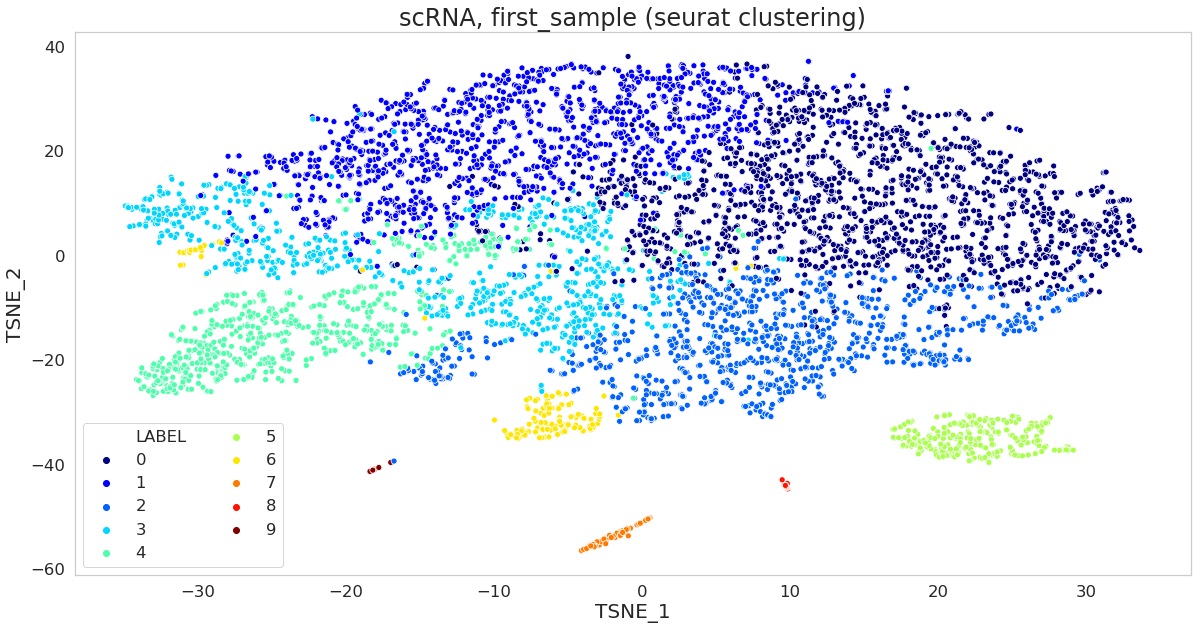

In [19]:
plt.figure(figsize=(20,10))
sns.set(font_scale=1.5, style="whitegrid")
ax = sns.scatterplot(
    x="TSNE_1", 
    y="TSNE_2",
    data=clustering_df,
    hue="LABEL",
    palette="jet",
    legend="full"
)
ax.grid(False)
ax.set_title(
    f"{data_name}, {sample_name}"
    f" ({clustering_name} clustering)",
    fontsize=24
)
ax.set_xlabel("TSNE_1", fontsize=20)
ax.set_ylabel("TSNE_2", fontsize=20)
ax.legend(ncol=2).get_frame().set_facecolor("white")
sns.set(font_scale=1)

## Getting an ASE matrix and selecting informative genes from it

In [18]:
%%time
gene_counts_df = util.pickle_load(f"{sample_data_dir}/gene_counts.pkl")
ase_df = ase_matrix.compute_ase(
    gene_counts_df, 
    toolkit.extract_barcodes(gene_counts_df)
)
util.pickle_dump(ase_df, f"{sample_data_dir}/ase.pkl")
ase_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10224 entries, 0 to 10223
Columns: 6126 entries, AAACCTGCACATCCAA-1 to TTTGTCATCCCAAGAT-1
dtypes: float64(6126)
memory usage: 477.8 MB
CPU times: user 9.84 s, sys: 12.5 s, total: 22.4 s
Wall time: 29.9 s


Per column:
AAACCTGCACATCCAA-1    0.997164
AAACCTGCACTAGTAC-1    0.996088
AAACCTGCATCATCCC-1    0.997555
AAACCTGGTAGCTCCG-1    0.995794
AAACCTGGTCTAAACC-1    0.994914
                        ...   
TTTGTCAGTGCGCTTG-1    0.989241
TTTGTCAGTGTTTGTG-1    0.993642
TTTGTCAGTTAAAGAC-1    0.995794
TTTGTCATCATCGGAT-1    0.991784
TTTGTCATCCCAAGAT-1    0.995012
Length: 6126, dtype: float64
Per row:
0        0.990042
1        0.999674
2        0.999510
3        0.999347
4        0.996898
           ...   
10219    0.999347
10220    0.999837
10221    0.998368
10222    0.999837
10223    0.999837
Length: 10224, dtype: float64
In total:  0.9948370985516976


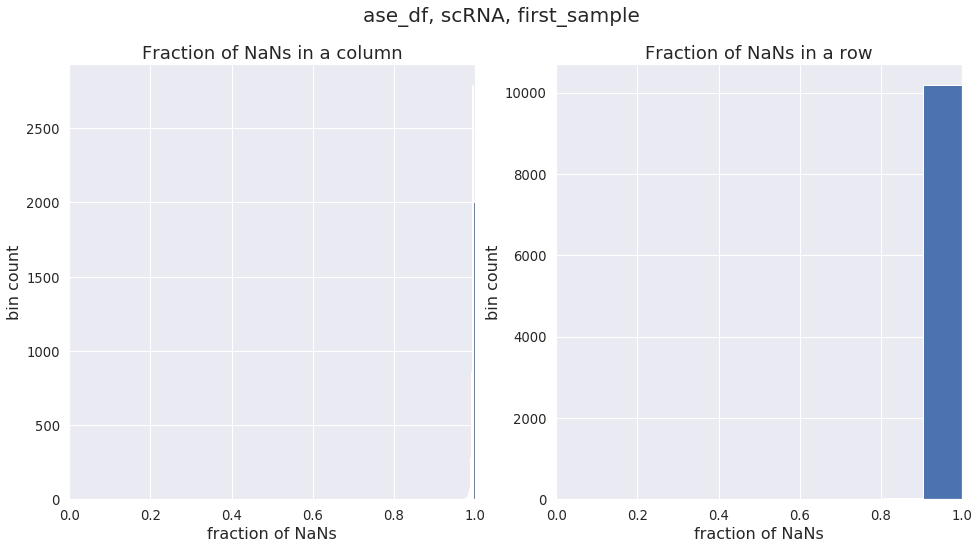

In [19]:
nan_info = util.nan_fraction(
    ase_df, 
    axis_list=[0,1],
    verbose=True, 
    show_plots=True,
    suptitle=f"ase_df, {data_name}, {sample_name}"
);

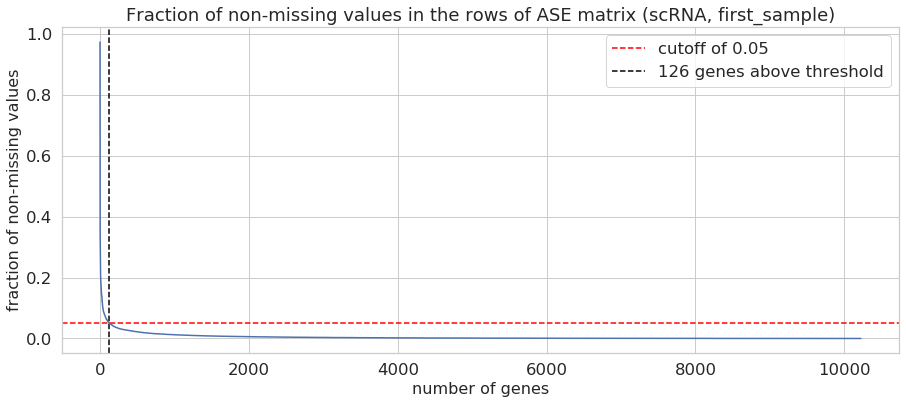

In [40]:
import ipywidgets as widgets

def plot_selection_by_nan_fraction(nan_info, cutoff=0.1, outfile=os.devnull):
    plt.figure(figsize=(15,6))
    plt.title("Fraction of non-missing values in the rows of ASE matrix ({}, {})"\
              .format(data_name, sample_name), fontsize=18)
    plt.xlabel("number of genes", fontsize=16);
    plt.ylabel("fraction of non-missing values", fontsize=16)
    n_remaining_genes = (1 - nan_info["row"] >= 1 - cutoff).sum()
    plt.axhline(
        1-cutoff, 
        color="red", 
        linestyle="--", 
        label="cutoff of {:.2f}".format(1-cutoff)
    );
    plt.axvline(n_remaining_genes, 
                color="black", linestyle="--", 
                label=f"{n_remaining_genes} genes above threshold")
    plt.plot(sorted(1 - nan_info["row"])[::-1]);
    plt.legend().get_frame().set_facecolor("white");
    plt.savefig(outfile, format=outfile.split('.')[-1], dpi=300)

plot_selection_by_nan_fraction(
    nan_info, 
    cutoff=0.95, 
    outfile=f"{sample_img_dir}/nans_with_threshold.pdf"
)